In [179]:
import os 

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nbimporter
import Useful_Visualization_Functions
from pyspark.ml import *
from pyspark.sql import *
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
"""
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from pyspark.sql.functions import *
"""
warnings.filterwarnings("ignore")
import pyspark.sql.functions as F

In [125]:
# from pyspark.sql import SparkSession
# from pyspark.sql import Row
# from pyspark.sql.functions import lit, col, column, expr, desc, asc

In [126]:
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install ipynb
# ! pip install nbimporter

In [127]:
# build our own SparkSession
myspark = SparkSession\
    .builder\
    .appName("AWS-Spark")\
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

In [128]:
myspark

In [129]:
# ! head noaa.csv
# noaa_data.show(10)
noaa_data = myspark.read.load("noaa.csv", format="csv", sep=",", header=True, inferSchema=True)
noaa_data.count()

22601

In [130]:
# noaa_data.show(10)

In [131]:
# temp_filt = (noaa_data.filter(noaa_data.ELEVATION <= 5))
# temp_filt.count()

In [132]:
#latitude_order = noaa_data.orderBy("LATITUDE", ascending=False)
#latitude_order.show(10)

In [133]:
noaa_data.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- TEMP_ATTRIBUTES: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- DEWP_ATTRIBUTES: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- VISIB_ATTRIBUTES: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- WDSP_ATTRIBUTES: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: double (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable = 

In [134]:
noaa_data.select("TEMP", "ELEVATION", "VISIB").show(10)

+----+---------+-----+
|TEMP|ELEVATION|VISIB|
+----+---------+-----+
|23.4|      9.0| 28.0|
|31.5|      9.0|  4.9|
|35.0|      9.0|  3.1|
|35.4|      9.0|  6.1|
|27.5|      9.0| 13.5|
|23.6|      9.0|  8.6|
|18.7|      9.0|  4.1|
|26.9|      9.0|999.9|
|31.7|      9.0|  5.9|
|32.1|      9.0|  5.4|
+----+---------+-----+
only showing top 10 rows



In [151]:


noaa_data = noaa_data.withColumn("ItRained", when((F.length(noaa_data["FRSHTT"]) <= 4), lit(0)) \
                    .when(F.length(noaa_data["FRSHTT"]) == 5, lit(1)) \
                    .otherwise(lit(substring('FRSHTT', 2, 1).cast(IntegerType()))) \
)

noaa_data.show(10)

+----------+----------+----------+----------+---------+--------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+-----+---------------+-----+------+--------+
|   STATION|      DATE|  LATITUDE| LONGITUDE|ELEVATION|                NAME|TEMP|TEMP_ATTRIBUTES|DEWP|DEWP_ATTRIBUTES|   SLP|SLP_ATTRIBUTES|  STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES|WDSP|WDSP_ATTRIBUTES|MXSPD|GUST| MAX|MAX_ATTRIBUTES| MIN|MIN_ATTRIBUTES| PRCP|PRCP_ATTRIBUTES| SNDP|FRSHTT|ItRained|
+----------+----------+----------+----------+---------+--------------------+----+---------------+----+---------------+------+--------------+-----+--------------+-----+----------------+----+---------------+-----+----+----+--------------+----+--------------+-----+---------------+-----+------+--------+
|1001099999|2021-01-01|70.9333333|-8.6666667|      9.0|JAN MAYEN NOR NAV...|23.4|           24.0|

In [152]:

columns = noaa_data.columns
"""
for cl in columns:
    noaa_data.describe(cl).show()

for cl in columns:
    noaa_data.select(cl).distinct().show(10)
"""

'\nfor cl in columns:\n    noaa_data.describe(cl).show()\n\nfor cl in columns:\n    noaa_data.select(cl).distinct().show(10)\n'

In [153]:
cols_to_drop = ["STATION", "DATE", "LATITUDE", "LONGITUDE", "ELEVATION", "NAME", "TEMP_ATTRIBUTES", "DEWP_ATTRIBUTES",
               "SLP_ATTRIBUTES", "STP_ATTRIBUTES", "VISIB_ATTRIBUTES", "WDSP_ATTRIBUTES", "MAX_ATTRIBUTES",
               "MIN_ATTRIBUTES", "PRCP_ATTRIBUTES"]

cols_interest = [x for x in columns if x not in cols_to_drop]
df_interest_cols = noaa_data.select(cols_interest)

### Data cleansing

In [154]:
df_interest_cols.printSchema()
df_clean = df_interest_cols.dropna()
[df_interest_cols.count(), df_clean.count()]

columns = df_clean.columns
    
for cl in df_clean.columns: 
    df_clean.select(cl).summary().show()
    
"""
for cl in columns:
    df_clean.describe(cl).show()


for cl in columns:
    df_clean.select(cl).distinct().show(10)
"""


root
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MIN: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNDP: double (nullable = true)
 |-- FRSHTT: integer (nullable = true)
 |-- ItRained: integer (nullable = true)

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|            22601|
|   mean|38.10303968850951|
| stddev| 14.0785718697824|
|    min|            -29.7|
|    25%|             29.4|
|    50%|             39.0|
|    75%|             48.5|
|    max|             79.3|
+-------+-----------------+

+-------+------------------+
|summary|              DEWP|
+-------+------------------+
|  count|             22601|
|   mean| 667.6748816424214|
| 

'\nfor cl in columns:\n    df_clean.describe(cl).show()\n\n\nfor cl in columns:\n    df_clean.select(cl).distinct().show(10)\n'

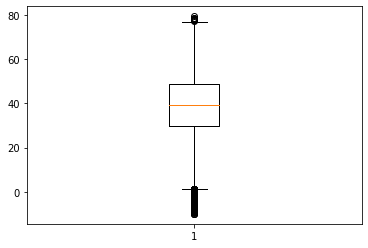

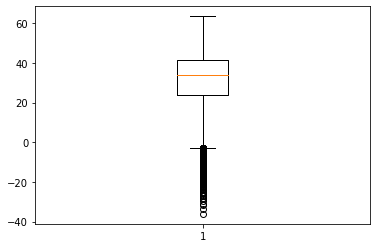

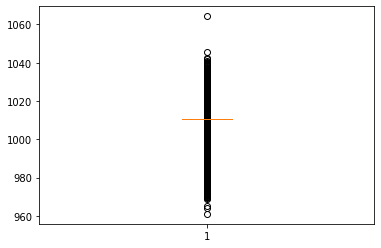

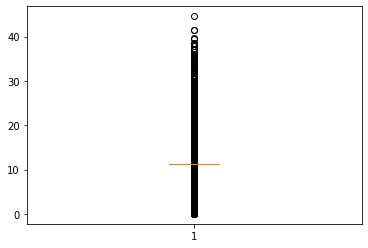

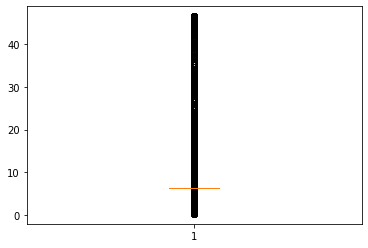

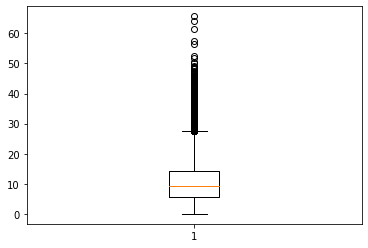

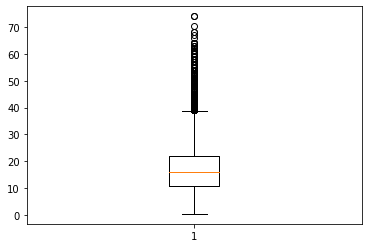

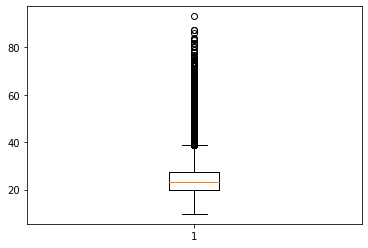

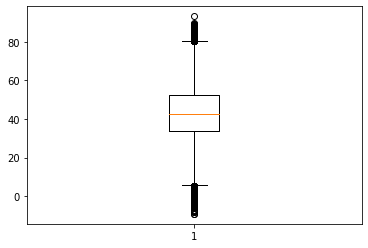

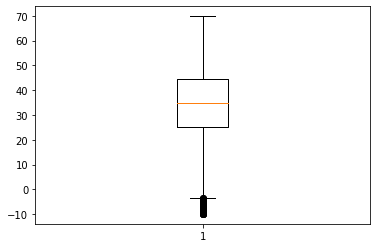

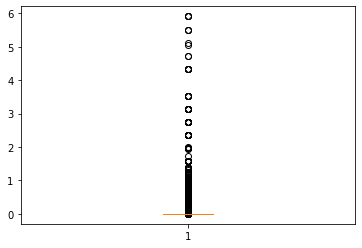

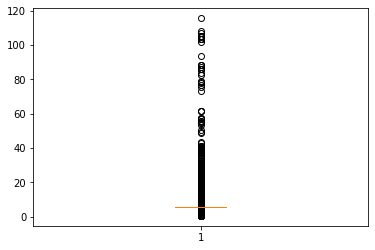

In [155]:
df_clean_pd = df_clean.toPandas()

temp_median = df_clean_pd['TEMP'].quantile(0.50)
df_clean_pd['TEMP'] = np.where(df_clean_pd['TEMP'] < -10, temp_median, df_clean_pd['TEMP'])
plt.boxplot(df_clean_pd["TEMP"])
plt.show()

dewp_median = df_clean_pd['DEWP'].quantile(0.50)
df_clean_pd['DEWP'] = np.where(df_clean_pd['DEWP'] > 100, dewp_median, df_clean_pd['DEWP'])
plt.boxplot(df_clean_pd["DEWP"])
plt.show()

df_clean_slp_filter = df_clean.filter(df_clean.SLP < 4000).toPandas()
slp_median = df_clean_slp_filter['SLP'].quantile(0.50)
df_clean_pd['SLP'] = np.where(df_clean_pd['SLP'] > 4000, slp_median, df_clean_pd['SLP'])
plt.boxplot(df_clean_pd["SLP"])
plt.show()

df_clean_stp_filter = df_clean.filter(df_clean.STP < 100).toPandas()
stp_median = df_clean_stp_filter['STP'].quantile(0.50)
df_clean_pd['STP'] = np.where(df_clean_pd['STP'] > 100, stp_median, df_clean_pd['STP'])
plt.boxplot(df_clean_pd["STP"])
plt.show()

df_clean_visib_filter = df_clean.filter(df_clean.VISIB < 100).toPandas()
visib_median = df_clean_visib_filter['VISIB'].quantile(0.50)
df_clean_pd['VISIB'] = np.where(df_clean_pd['VISIB'] > 100, visib_median, df_clean_pd['VISIB'])
plt.boxplot(df_clean_pd["VISIB"])
plt.show()

df_clean_wdsp_filter = df_clean.filter(df_clean.WDSP < 100).toPandas()
wdsp_median = df_clean_wdsp_filter['WDSP'].quantile(0.50)
df_clean_pd['WDSP'] = np.where(df_clean_pd['WDSP'] > 100, wdsp_median, df_clean_pd['WDSP'])
plt.boxplot(df_clean_pd["WDSP"])
plt.show()

df_clean_mxspd_filter = df_clean.filter(df_clean.MXSPD < 100).toPandas()
mxspd_median = df_clean_mxspd_filter['MXSPD'].quantile(0.50)
df_clean_pd['MXSPD'] = np.where(df_clean_pd['MXSPD'] > 100, mxspd_median, df_clean_pd['MXSPD'])
plt.boxplot(df_clean_pd["MXSPD"])
plt.show()

df_clean_gust_filter = df_clean.filter(df_clean.GUST < 100).toPandas()
gust_median = df_clean_gust_filter['GUST'].quantile(0.50)
df_clean_pd['GUST'] = np.where(df_clean_pd['GUST'] > 100, gust_median, df_clean_pd['GUST'])
plt.boxplot(df_clean_pd["GUST"])
plt.show()

df_clean_max_filter = df_clean.filter(df_clean.MAX < 100).toPandas()
max_median = df_clean_max_filter['MAX'].quantile(0.50)
df_clean_pd['MAX'] = np.where((df_clean_pd['MAX'] < 100) & (df_clean_pd['MAX'] > -10), df_clean_pd['MAX'], max_median)
plt.boxplot(df_clean_pd["MAX"])
plt.show()

df_clean_min_filter = df_clean.filter(df_clean.MIN < 100).toPandas()
min_median = df_clean_max_filter['MIN'].quantile(0.50)
df_clean_pd['MIN'] = np.where((df_clean_pd['MIN'] < 100) & (df_clean_pd['MIN'] > -10), df_clean_pd['MIN'], min_median)
plt.boxplot(df_clean_pd["MIN"])
plt.show()

df_clean_prcp_filter = df_clean.filter(df_clean.PRCP < 100).toPandas()
prcp_median = df_clean_prcp_filter['PRCP'].quantile(0.50)
df_clean_pd['PRCP'] = np.where(df_clean_pd['PRCP'] > 50, prcp_median, df_clean_pd['PRCP'])
plt.boxplot(df_clean_pd["PRCP"])
plt.show()

df_clean_sndp_filter = df_clean.filter(df_clean.SNDP < 100).toPandas()
sndp_median = df_clean_sndp_filter['SNDP'].quantile(0.50)
df_clean_pd['SNDP'] = np.where(df_clean_pd['SNDP'] > 200, sndp_median, df_clean_pd['SNDP'])
plt.boxplot(df_clean_pd["SNDP"])
plt.show()

In [156]:
df_clean = myspark.createDataFrame(df_clean_pd)
df_train, df_test = df_clean.randomSplit([0.8,0.2], seed = 42)
df_train.cache()
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set")

There are 18133 rows in the training set and 4468 in the test set


In [200]:
vec_assembler = VectorAssembler(inputCols=['TEMP', 'DEWP','SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN'], outputCol="features")
vec_df_train = vec_assembler.transform(df_train)

# show the content of the columns bedrooms, features and price
# vec_df_train.select("TEMP","DEWP","features").show(200)

lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="ItRained")
pipeline = Pipeline(stages=[vec_assembler, lsvc])
pipeline_model = pipeline.fit(df_train)
df_prediction = pipeline_model.transform(df_test)
df_prediction.select("features", "ItRained", "prediction").sort("prediction", ascending=False).show(200)

"""
prediction_label = df_prediction.select("prediction", "ItRained")

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))

lr = LinearRegression(featuresCol="features", labelCol="ItRained")
lr_model = lr.fit(vec_df_train)
avg_ItRained = float(df_train.select(avg("ItRained")).first()[0])
df_pred = df_train.withColumn("avg_ItRained_prediction", lit(avg_ItRained))
avg_ItRained
evaluator = RegressionEvaluator(predictionCol="avg_ItRained_prediction", labelCol="ItRained", metricName="rmse")
print(f"The RMSE for predicting the average frshtt is: {evaluator.evaluate(df_pred):.2f}")
pipeline = Pipeline(stages=[vec_assembler, lr_model])

# get the model (as transformer)
pipeline_model = pipeline.fit(df_train)
df_prediction = pipeline_model.transform(df_test)

# show the columns worth to be looked at
df_prediction.select("features","ItRained","prediction").sample(False, 0.1).sort("ItRained", ascending=False).show(200)

df_prediction.columns
"""

+--------------------+--------+----------+
|            features|ItRained|prediction|
+--------------------+--------+----------+
|[44.4,37.6,1010.8...|       1|       1.0|
|[33.0,24.0,1010.8...|       1|       1.0|
|[55.0,46.3,1010.8...|       1|       1.0|
|[47.5,38.7,1010.8...|       1|       1.0|
|[44.2,37.6,1010.8...|       1|       1.0|
|[48.1,45.4,1010.8...|       1|       1.0|
|[46.0,43.5,1010.8...|       1|       1.0|
|[54.9,51.9,1010.8...|       1|       1.0|
|[60.8,56.0,1010.8...|       0|       1.0|
|[50.6,42.0,1010.8...|       1|       1.0|
|[26.2,19.4,1010.8...|       0|       1.0|
|[52.4,51.2,1010.8...|       1|       1.0|
|[40.2,34.0,1010.8...|       0|       1.0|
|[44.5,41.8,1010.8...|       1|       1.0|
|[40.5,32.0,1010.8...|       1|       1.0|
|[41.7,30.7,1010.8...|       1|       1.0|
|[43.2,38.5,1010.8...|       1|       1.0|
|[54.1,49.4,1010.8...|       1|       1.0|
|[48.4,46.2,1010.8...|       1|       1.0|
|[49.1,45.5,1010.8...|       1|       1.0|
|[58.4,56.6

'\nprediction_label = df_prediction.select("prediction", "ItRained")\n\nevaluator = BinaryClassificationEvaluator(rawPredictionCol=\'prediction\')\n\nprint("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))\n\nlr = LinearRegression(featuresCol="features", labelCol="ItRained")\nlr_model = lr.fit(vec_df_train)\navg_ItRained = float(df_train.select(avg("ItRained")).first()[0])\ndf_pred = df_train.withColumn("avg_ItRained_prediction", lit(avg_ItRained))\navg_ItRained\nevaluator = RegressionEvaluator(predictionCol="avg_ItRained_prediction", labelCol="ItRained", metricName="rmse")\nprint(f"The RMSE for predicting the average frshtt is: {evaluator.evaluate(df_pred):.2f}")\npipeline = Pipeline(stages=[vec_assembler, lr_model])\n\n# get the model (as transformer)\npipeline_model = pipeline.fit(df_train)\ndf_prediction = pipeline_model.transform(df_test)\n\n# show the columns worth to be looked at\ndf_prediction.select("features","ItRained","prediction").sample(False, 0.1).sort("ItRa

In [191]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
# Compute raw scores on the test set




model = lsvc

predictionAndLabels = df_test.rdd.map(lambda lp: (float(model.predict(lp.features)), lp.label))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

IllegalArgumentException: features does not exist. Available: TEMP, DEWP, SLP, STP, VISIB, WDSP, MXSPD, GUST, MAX, MIN, PRCP, SNDP, FRSHTT, ItRained

The RMSE for predicting the average frshtt is: 0.46
